In [2]:
# Download from https://github.com/facebookresearch/segment-anything
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from glob import glob
import h5py
from multiprocessing import Pool, cpu_count
import os
import cv2

# (Done! No need to run) SAM model to masks

In [3]:
def show_anns(anns):
    if len(anns) == 0: return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
        
    return img

def read_all_frames(folder):
    frames = []
    for i in range(129):
        image_path = os.path.join(folder, f'{i:03d}.png')
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        frames.append(image)
    return frames

all_frames = read_all_frames("../data") ; print(np.array(all_frames).shape)

(129, 2160, 3840)


In [4]:
sam = sam_model_registry["default"](checkpoint="../DL_model/sam_vit_h_4b8939.pth").to("cuda")
mask_generator = SamAutomaticMaskGenerator(
    model                          = sam,
    points_per_side                = 16,
    points_per_batch               = 64,
    pred_iou_thresh                = 0.88,
    stability_score_thresh         = 0.95,
    stability_score_offset         = 1.0,
    box_nms_thresh                 = 0.7,
    crop_n_layers                  = 0,
    crop_nms_thresh                = 0.7,
    crop_overlap_ratio             = 512 / 1500,
    crop_n_points_downscale_factor = 1,
    point_grids                    = None,
    min_mask_region_area           = 0,
    )

  0%|          | 0/129 [00:00<?, ?it/s]

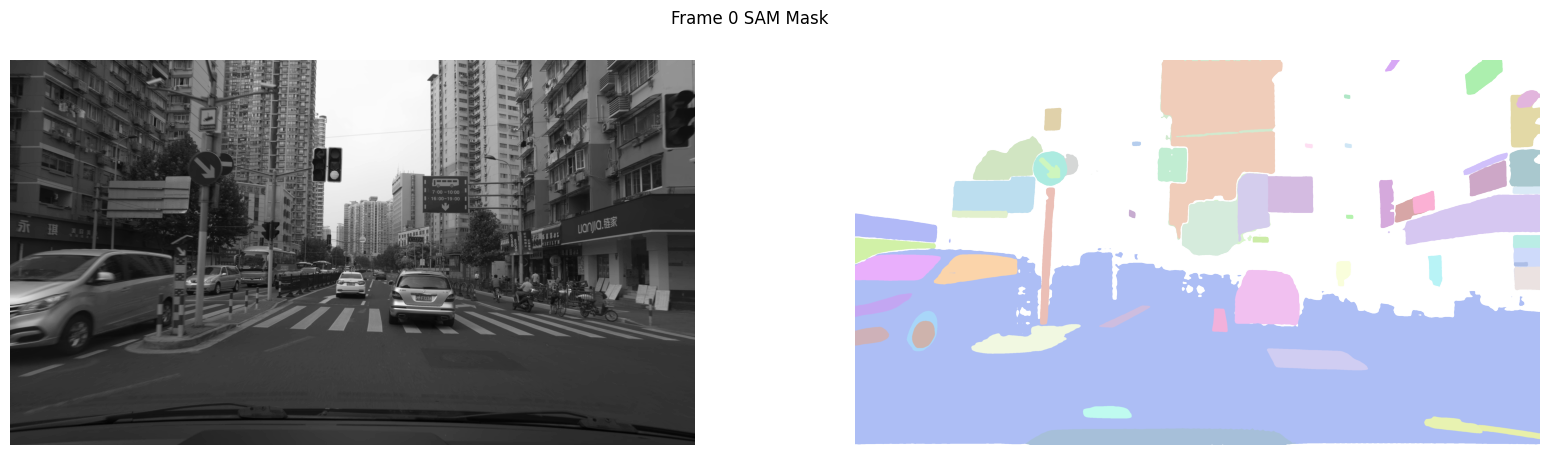

  0%|          | 0/129 [00:03<?, ?it/s]


In [5]:
for i in trange(len(all_frames)):
    
    mask = mask_generator.generate(np.array([all_frames[i] for _ in range(3)]).swapaxes(0, 2)) # (w, h, RGB)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    label_img = show_anns(mask)

    ax[0].imshow(all_frames[i], cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(label_img.swapaxes(0, 1))
    ax[1].axis('off')
    plt.suptitle(f'Frame {i} SAM Mask')
    plt.show()
    # plt.savefig(f'../Masks/{i:03d}.png', bbox_inches='tight')
    # plt.close('all')
    
    # np.save(f"../Masks/{i:03d}.npy", np.array(mask))
    
    break

# (Done! No need to run) Masks to h5 & txt

In [15]:
def process_mask_file(mask_file):
    if os.path.exists(f'../DL_masks/SAM_masks_h5/{mask_file.split("/")[-1].split(".")[0]}.h5'):
        print(f"Skipping {mask_file}")
        return
    all_labels = np.load(mask_file, allow_pickle=True)
    name = mask_file.split('/')[-1].split('.')[0]
    # list of dict, ['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box']
    
    segmentations, areas, bboxs, predicted_ious, point_coordss, stability_scores, crop_boxs = [], [], [], [], [], [], []

    for label in all_labels:
        segmentations.append(label["segmentation"].T)
        areas.append(label["area"])
        bboxs.append(label["bbox"])
        predicted_ious.append(label["predicted_iou"])
        point_coordss.append(label["point_coords"])
        stability_scores.append(label["stability_score"])
        crop_boxs.append(label["crop_box"])
        
    with h5py.File(f'../DL_masks/SAM_masks_h5/{name}.h5', 'w') as hf:
        hf.create_dataset('segmentations', data=np.array(segmentations), compression="gzip")
        hf.create_dataset('areas', data=np.array(areas), compression="gzip")
        hf.create_dataset('bboxs', data=np.array(bboxs), compression="gzip")
        hf.create_dataset('predicted_ious', data=np.array(predicted_ious), compression="gzip")
        hf.create_dataset('point_coordss', data=np.array(point_coordss), compression="gzip")
        hf.create_dataset('stability_scores', data=np.array(stability_scores), compression="gzip")
        hf.create_dataset('crop_boxs', data=np.array(crop_boxs), compression="gzip")
       
    # break

In [16]:
mask_files = sorted(glob('../Masks/*.npy'))    
with Pool(cpu_count()) as pool:
    list(tqdm(pool.imap(process_mask_file, mask_files), total=len(mask_files)))

100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


# Get object masks

In [6]:
def read_all_frames(folder):
    frames = []
    for i in range(129):
        image_path = os.path.join(folder, f'{i:03d}.png')
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        frames.append(image)
    return frames

all_frames = read_all_frames("../data") ; print(np.array(all_frames).shape)
h5_masks = sorted(glob('../DL_masks/SAM_masks_h5/*.h5'))

(129, 2160, 3840)


In [8]:
# Open h5 mask
for idx, h5_mask in enumerate(h5_masks):
    try:
        data = h5py.File(h5_mask, 'r')
        name = h5_mask.split('/')[-1].split('.')[0]
        segmentations = data['segmentations']
        # print(data.keys())
        # print(h5_mask, segmentations.shape)
    except Exception as e:
        print(e, h5_mask)
        continue

<KeysViewHDF5 ['areas', 'bboxs', 'crop_boxs', 'point_coordss', 'predicted_ious', 'segmentations', 'stability_scores']>
../DL_masks/SAM_masks_h5/000.h5 (133, 2160, 3840)


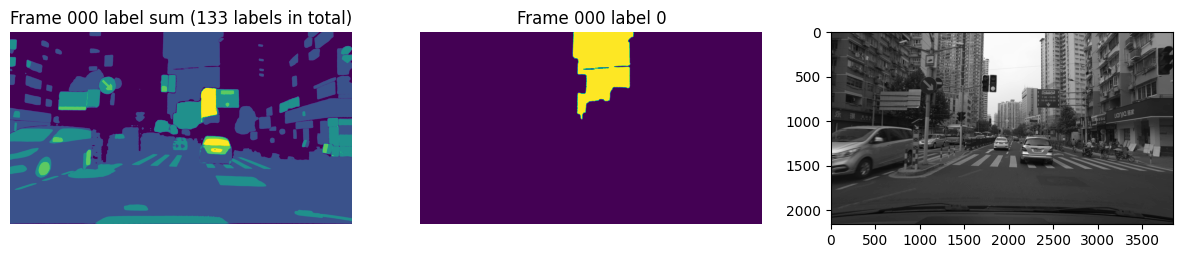

<KeysViewHDF5 ['areas', 'bboxs', 'crop_boxs', 'point_coordss', 'predicted_ious', 'segmentations', 'stability_scores']>
../DL_masks/SAM_masks_h5/001.h5 (137, 2160, 3840)


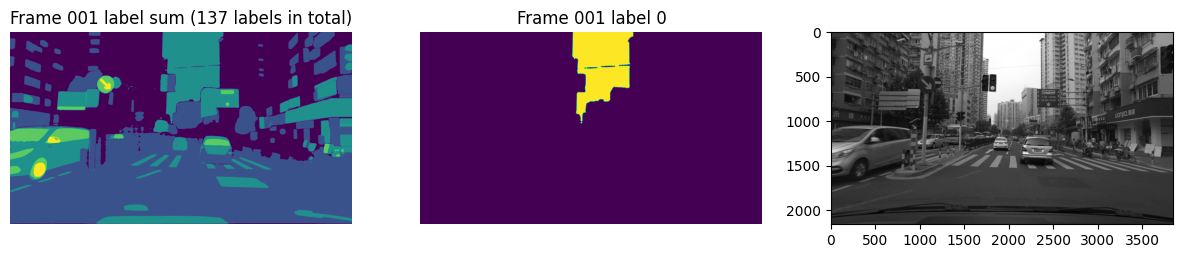

<KeysViewHDF5 ['areas', 'bboxs', 'crop_boxs', 'point_coordss', 'predicted_ious', 'segmentations', 'stability_scores']>
../DL_masks/SAM_masks_h5/002.h5 (129, 2160, 3840)


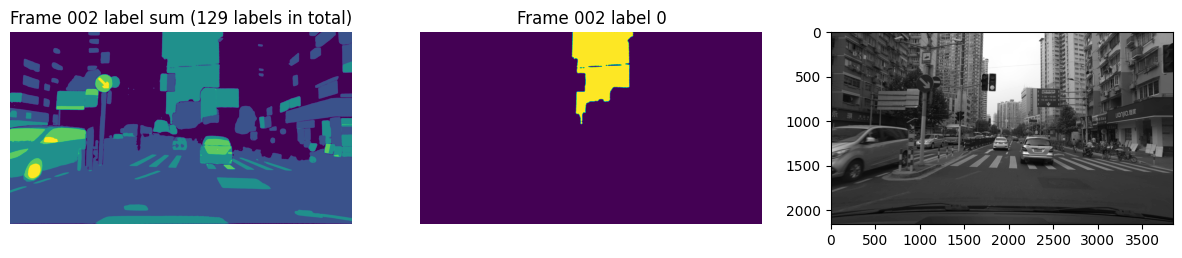

In [9]:
# Open h5 mask
for idx, h5_mask in enumerate(h5_masks):
    data = h5py.File(h5_mask, 'r')
    name = h5_mask.split('/')[-1].split('.')[0]
    segmentations = data['segmentations'][:]
    print(data.keys())
    print(h5_mask, segmentations.shape)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(segmentations.sum(0))
    ax[0].axis('off')
    ax[0].set_title(f"Frame {name} label sum ({segmentations.shape[0]} labels in total)")
    ax[1].imshow(segmentations[0])
    ax[1].axis('off')
    ax[1].set_title(f"Frame {name} label 0")
    ax[2].imshow(all_frames[idx], cmap='gray')
    
    plt.show()
    if idx == 2: break